# Bayesian Synthesis: Compositional Gaussian Processes

This notebook is a runnable, end-to-end walkthrough of the core idea from the paper:
**compose kernels with a grammar, fit GP hyperparameters, and search over structures**.

We use the classic **AirPassengers** monthly airline passenger volume dataset (1949–1960) and:
1. Define a compositional kernel grammar for GPs
2. Fit hyperparameters for a fixed structure (MAP)
3. Run an adaptive random search to discover good structures
4. Visualize fits on a held-out time window


## Background and framing

There are a few ways to connect program synthesis and probabilistic inference:
1. Use probabilistic inference for program synthesis
2. Use program synthesis for probabilistic modeling
3. Use probabilistic inference to synthesize probabilistic programs

This notebook focuses on (3), following the paper **Bayesian Synthesis of Probabilistic Programs for Automatic Data Modeling**. We keep the implementation small and runnable, while capturing the core semantics and the inference intuition.

## 0. Setup
We use standard scientific Python packages.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

### 0.1) Dataset: AirPassengers (Box & Jenkins)

Monthly totals of international airline passengers, 1949–1960 (12 years × 12 months = 144 points). We embed the values directly to avoid any external dependency.

We model the **log** series and center it to match the zero-mean GP assumption.


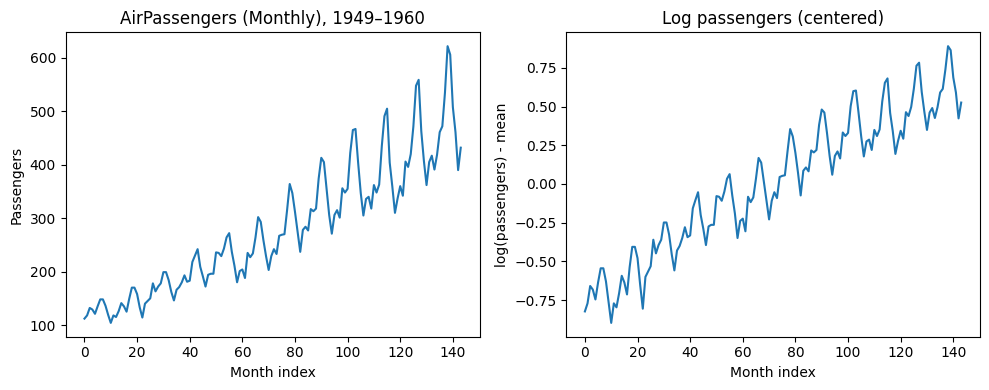

In [2]:
air_passengers = np.array([
    112,118,132,129,121,135,148,148,136,119,104,118,
    115,126,141,135,125,149,170,170,158,133,114,140,
    145,150,178,163,172,178,199,199,184,162,146,166,
    171,180,193,181,183,218,230,242,209,191,172,194,
    196,196,236,235,229,243,264,272,237,211,180,201,
    204,188,235,227,234,264,302,293,259,229,203,229,
    242,233,267,269,270,315,364,347,312,274,237,278,
    284,277,317,313,318,374,413,405,355,306,271,306,
    315,301,356,348,355,422,465,467,404,347,305,336,
    340,318,362,348,363,435,491,505,404,359,310,337,
    360,342,406,396,420,472,548,559,463,407,362,405,
    417,391,419,461,472,535,622,606,508,461,390,432
], dtype=float)

# Time index in months (0..143)
t = np.arange(len(air_passengers), dtype=float)

# Log-transform and center to support a zero-mean GP
y_log = np.log(air_passengers)
y_mean = float(y_log.mean())
y = y_log - y_mean

len(t), y[:5], y[-5:]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, air_passengers)
plt.title("AirPassengers (Monthly), 1949–1960")
plt.xlabel("Month index")
plt.ylabel("Passengers")

plt.subplot(1, 2, 2)
plt.plot(t, y)
plt.title("Log passengers (centered)")
plt.xlabel("Month index")
plt.ylabel("log(passengers) - mean")
plt.tight_layout()
plt.show()


## 0.2) Train/holdout split (time-series)

We hold out the **last N months** for evaluation so that we can plot **predictions vs actual** on unseen data.

- Training set: months $[0, \dots, T-N-1]$
- Holdout set: months $[T-N, \dots, T-1]$


In [3]:
# Keep a copy of the full series for plotting
X_full = t
# y is centered log-passengers
y_full = y

holdout_n = 24  # last 24 months
split_idx = len(X_full) - holdout_n

X_train, y_train = X_full[:split_idx], y_full[:split_idx]
X_holdout, y_holdout = X_full[split_idx:], y_full[split_idx:]

print("Train n:", len(X_train), "Holdout n:", len(X_holdout), "Split idx:", split_idx)

# For the rest of the notebook, use TRAIN ONLY by default.
X = X_train
y = y_train

Train n: 120 Holdout n: 24 Split idx: 120


## Problem statement (Bayesian synthesis)

We start with:
- A language $\mathcal{L}$ (formalized later via a tagged PCFG)
- A domain $\mathcal{X}$ (the data we want to model)

Each expression $E \in \mathcal{L}$ has two semantic functions:
- **Prior**: $\mathsf{Prior}: \mathcal{L} \to (0,1]$
- **Likelihood**: $\mathsf{Lik}: \mathcal{L} \to (\mathcal{X} \to \mathbb{R}_{\ge 0})$

**Bounded and normalized:** to be valid distributions, these functions must be bounded and normalized. The paper shows that this holds for tagged PCFGs, which lets us define a posterior.

Assuming both are bounded and normalized, we define the posterior semantic function:
$$
\mathsf{Post}\llbracket E \rrbracket(X) = \frac{\mathsf{Prior}\llbracket E \rrbracket \cdot \mathsf{Lik}\llbracket E \rrbracket(X)}{\sum_{E' \in \mathcal{L}} \mathsf{Prior}\llbracket E' \rrbracket \cdot \mathsf{Lik}\llbracket E' \rrbracket(X)}
$$

**Objective (Bayesian Synthesis):** given data $X \in \mathcal{X}$, generate expressions $E$ with probability $\mathsf{Post}\llbracket E \rrbracket(X)$.


## 0.3) Kernel Grammar (Composable Kernel AST)

**Gaussian Process:**
$$
f \sim \mathbf{GP}(0, k(x, x')), \quad y = f(x) + \epsilon, \quad \epsilon \sim \mathbf{N}(0, \sigma_n^2)
$$

**Kernel Grammar (BNF):**
```
K  ::=  K + K          (Sum)
     |  K × K          (Product)
     |  RBF            (Squared Exponential)
     |  Periodic       (Periodic / Seasonal)
     |  Linear         (Linear trend)
     |  White          (White noise)
```

**Base kernel definitions:**
- $k_{\text{RBF}}(x,x') = \sigma^2 \exp\left(-\frac{(x-x')^2}{2\ell^2}\right)$
- $k_{\text{Per}}(x,x') = \sigma^2 \exp\left(-\frac{2\sin^2(\pi|x-x'|/p)}{\ell^2}\right)$
- $k_{\text{Lin}}(x,x') = \sigma^2 (x-c)(x'-c)$
- $k_{\text{WN}}(x,x') = \sigma^2 \mathbf{1}_{x=x'}$

**Probabilistic sampler:** We sample random kernel expressions with probabilities $p_{\text{sum}}, p_{\text{prod}}, p_{\text{base}}$ at each depth level.


### Tagged PCFG semantics (conceptual)

The paper uses a **tagged probabilistic context-free grammar (PCFG)**
$G = \langle \Sigma, N, R, T, P, Q, S \rangle$ with:
- terminals $\Sigma$, non-terminals $N$, and start symbol $S$
- production rules $R_{ik} = \langle N_i, T_{ik}, \tilde N_1, \ldots, \tilde N_{h_{ik}} \rangle$
- tag probabilities $P(T_{ik})$ (for each $N_i$, tags sum to 1)
- terminal probabilities $Q(T_{ik}, s)$ (for each tag, terminals sum to 1)

This yields an inductive **Expand** semantics:
$$
\mathsf{Expand}\llbracket (T_{ik}\ s) \rrbracket (N_i) = P(T_{ik}) Q(T_{ik}, s)
$$
$$
\mathsf{Expand}\llbracket (T_{ik}\ E_1 \cdots E_{h_{ik}}) \rrbracket (N_i) = P(T_{ik}) \prod_{z=1}^{h_{ik}} \mathsf{Expand}\llbracket E_z \rrbracket(\tilde N_z)
$$

In this notebook, the kernel grammar plays the role of $\mathcal{L}$, and the prior over kernels is induced by grammar weights (a simplified instance of $P$ and $Q$).

### Mutation and transition distribution (MCMC details)

Let $A$ be the set of parse-tree indices, and $A_E \subset A$ the nodes present in expression $E$.
Define $\mathsf{SubExpr}_a\llbracket E \rrbracket$ as the subtree at index $a$, and
$\mathsf{Sever}_a\llbracket E \rrbracket = (N_i, E_{\text{hole}})$ as the non-terminal at the cut plus a hole context.

A **mutation** is:
1. sample $a \sim \text{Uniform}(A_E)$
2. sever at $a$ to get $(N_i, E_{\text{hole}})$
3. sample a new subtree $E_{\text{sub}} \sim \mathsf{Expand}(\cdot\mid N_i)$
4. set $E' = E_{\text{hole}}\llbracket E_{\text{sub}} \rrbracket$

This defines a **proposal distribution** $\mathcal{T}(E \to E')$ by averaging over node choices:
$$
\mathcal{T}(E \to E') = \frac{1}{|A_E|} \sum_{a \in A_E \cap A_{E'}} \mathsf{Expand}\llbracket \mathsf{SubExpr}_a\llbracket E' \rrbracket \rrbracket(N_i)
$$
when severing at $a$ yields the same hole in both $E$ and $E'$ (and $0$ otherwise).

The **Metropolis–Hastings acceptance** uses the target posterior
$\pi(E) \propto \mathsf{Prior}\llbracket E \rrbracket \cdot \mathsf{Lik}\llbracket E \rrbracket(X)$:
$$
\alpha(E, E') = \min\left(1, \frac{|A_E|}{|A_{E'}|} \cdot \frac{\pi(E')}{\pi(E)}\right)
$$

This is the formal “transform distribution” that the blog alludes to.

In [4]:
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Union

Array = np.ndarray
Params = Dict[str, float]

# Safe exp to prevent overflow (clamp log-values to [-20, 20]), along with tools to infer GP
def _safe_exp(x: float, lo: float = -20.0, hi: float = 20.0) -> float:
    return float(np.exp(np.clip(x, lo, hi)))

def _norm_base_weights(base_weights: dict[str, float] | None) -> dict[str, float]:
    """Normalize base kernel weights to sum to 1."""
    bw = dict(base_weights or {"rbf": 0.35, "per": 0.35, "lin": 0.20, "wn": 0.10})
    for k in ("rbf", "per", "lin", "wn"):
        bw.setdefault(k, 0.0)
    s = float(sum(bw.values()))
    if not np.isfinite(s) or s <= 0:
        return {"rbf": 0.25, "per": 0.25, "lin": 0.25, "wn": 0.25}
    return {k: float(v) / s for k, v in bw.items()}

def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def stable_cholesky(K, jitter=1e-6, max_tries=5):
    """Cholesky with adaptive jitter for numerical stability."""
    j = jitter
    for _ in range(max_tries):
        try:
            L = np.linalg.cholesky(K + j * np.eye(K.shape[0]))
            return L, j
        except np.linalg.LinAlgError:
            j *= 10
    raise np.linalg.LinAlgError("Cholesky failed even with increased jitter")

def solve_cholesky(L, b):
    """Solve (L L^T) x = b."""
    y = np.linalg.solve(L, b)
    x = np.linalg.solve(L.T, y)
    return x




In [5]:
@dataclass
class GrammarParams:
    """Grammar parameters for kernel structure sampling."""
    base_weights: dict[str, float]  # keys: rbf/per/lin/wn
    p_sum: float
    p_prod: float

    @classmethod
    def default(cls) -> "GrammarParams":
        return cls(
            base_weights={"rbf": 0.35, "per": 0.35, "lin": 0.20, "wn": 0.10},
            p_sum=0.35,
            p_prod=0.35,
        )

    def normalized(self) -> "GrammarParams":
        """Return a copy with normalized base_weights."""
        return GrammarParams(
            base_weights=_norm_base_weights(self.base_weights),
            p_sum=self.p_sum,
            p_prod=self.p_prod,
        )


class Kernel:
    def param_names(self) -> List[str]:
        raise NotImplementedError

    def __call__(self, X: Array, X2: Optional[Array], p: Params) -> Array:
        raise NotImplementedError

    def pretty(self) -> str:
        raise NotImplementedError


@dataclass(frozen=True)
class RBF(Kernel):
    name: str = "rbf"

    def param_names(self) -> List[str]:
        return [f"{self.name}_log_amp", f"{self.name}_log_ell"]

    def __call__(self, X: Array, X2: Optional[Array], p: Params) -> Array:
        if X2 is None:
            X2 = X
        amp = _safe_exp(p[f"{self.name}_log_amp"])
        ell = _safe_exp(p[f"{self.name}_log_ell"])
        d2 = (X[:, None] - X2[None, :]) ** 2
        return (amp ** 2) * np.exp(-0.5 * d2 / (ell ** 2 + 1e-12))

    def pretty(self) -> str:
        return f"RBF({self.name})"


@dataclass(frozen=True)
class Periodic(Kernel):
    name: str = "per"

    def param_names(self) -> List[str]:
        return [f"{self.name}_log_amp", f"{self.name}_log_ell", f"{self.name}_log_period"]

    def __call__(self, X: Array, X2: Optional[Array], p: Params) -> Array:
        if X2 is None:
            X2 = X
        amp = _safe_exp(p[f"{self.name}_log_amp"])
        ell = _safe_exp(p[f"{self.name}_log_ell"])
        period = _safe_exp(p[f"{self.name}_log_period"])
        dist = np.pi * np.abs(X[:, None] - X2[None, :]) / (period + 1e-12)
        sin2 = np.sin(dist) ** 2
        return (amp ** 2) * np.exp(-2.0 * sin2 / (ell ** 2 + 1e-12))

    def pretty(self) -> str:
        return f"Periodic({self.name})"


@dataclass(frozen=True)
class Linear(Kernel):
    name: str = "lin"

    def param_names(self) -> List[str]:
        return [f"{self.name}_log_amp", f"{self.name}_log_c"]

    def __call__(self, X: Array, X2: Optional[Array], p: Params) -> Array:
        if X2 is None:
            X2 = X
        amp = _safe_exp(p[f"{self.name}_log_amp"])
        c = _safe_exp(p[f"{self.name}_log_c"])
        return (amp ** 2) * ((X[:, None] - c) * (X2[None, :] - c))

    def pretty(self) -> str:
        return f"Linear({self.name})"


@dataclass(frozen=True)
class White(Kernel):
    name: str = "wn"

    def param_names(self) -> List[str]:
        return [f"{self.name}_log_sigma"]

    def __call__(self, X: Array, X2: Optional[Array], p: Params) -> Array:
        # white noise only contributes when X2 is X
        sigma = _safe_exp(p[f"{self.name}_log_sigma"])
        if X2 is None:
            return (sigma ** 2) * np.eye(X.shape[0])
        if X2 is not X:
            return np.zeros((X.shape[0], X2.shape[0]))
        return (sigma ** 2) * np.eye(X.shape[0])

    def pretty(self) -> str:
        return f"White({self.name})"


@dataclass(frozen=True)
class Sum(Kernel):
    left: Kernel
    right: Kernel

    def param_names(self) -> List[str]:
        return self.left.param_names() + self.right.param_names()

    def __call__(self, X: Array, X2: Optional[Array], p: Params) -> Array:
        return self.left(X, X2, p) + self.right(X, X2, p)

    def pretty(self) -> str:
        return f"({self.left.pretty()} + {self.right.pretty()})"


@dataclass(frozen=True)
class Product(Kernel):
    left: Kernel
    right: Kernel

    def param_names(self) -> List[str]:
        return self.left.param_names() + self.right.param_names()

    def __call__(self, X: Array, X2: Optional[Array], p: Params) -> Array:
        return self.left(X, X2, p) * self.right(X, X2, p)

    def pretty(self) -> str:
        return f"({self.left.pretty()} * {self.right.pretty()})"


def init_params_for_kernel(k: Kernel, *, scale: float = 0.1) -> Params:
    """Initialize unconstrained (log-)params by traversing the kernel AST.

    This avoids parsing param names (no `_param_suffix`) and instead uses the
    kernel node types directly.
    """

    def n(mu: float) -> float:
        return float(mu + scale * np.random.randn())

    match k:
        case RBF(name=name):
            return {
                f"{name}_log_amp": n(math.log(1.0)),
                f"{name}_log_ell": n(math.log(10.0)),
            }

        case Periodic(name=name):
            return {
                f"{name}_log_amp": n(math.log(1.0)),
                f"{name}_log_ell": n(math.log(10.0)),
                f"{name}_log_period": n(math.log(12.0)),
            }

        case Linear(name=name):
            return {
                f"{name}_log_amp": n(math.log(1.0)),
                f"{name}_log_c": n(math.log(1.0)),
            }

        case White(name=name):
            return {f"{name}_log_sigma": n(math.log(0.1))}

        case Sum(left=left, right=right) | Product(left=left, right=right):
            p = init_params_for_kernel(left, scale=scale)
            p.update(init_params_for_kernel(right, scale=scale))
            return p

        case _:
            raise TypeError(f"Unknown kernel node type: {type(k).__name__}")


## 1. Sampling kernels from the grammar
We start by implementing a simple sampler that expands the grammar into a random kernel expression.

In [6]:
def sample_kernel_grammar(
    rng: np.random.Generator,
    depth: int = 2,
    grammar: GrammarParams | None = None,
) -> Kernel:
    """Sample a random kernel expression from the grammar.

    Args:
        rng: Random number generator.
        depth: Max recursion depth for Sum/Product expansions.
        grammar: Grammar parameters (defaults to GrammarParams.default()).
    """
    g = (grammar or GrammarParams.default()).normalized()
    keys = list(g.base_weights.keys())
    probs = np.array([g.base_weights[k] for k in keys], dtype=float)

    def rec(d: int) -> Kernel:
        if d > 0:
            u = rng.random()
            if u < g.p_sum:
                return Sum(rec(d - 1), rec(d - 1))
            if u < g.p_sum + g.p_prod:
                return Product(rec(d - 1), rec(d - 1))

        # base case
        choice = rng.choice(keys, p=probs / probs.sum())
        uid = int(rng.integers(1_000_000))
        match choice:
            case "rbf":
                return RBF(name=f"rbf{uid}")
            case "per":
                return Periodic(name=f"per{uid}")
            case "lin":
                return Linear(name=f"lin{uid}")
            case _:
                return White(name=f"wn{uid}")

    return rec(depth)




In [7]:
# Test: Try running this code to sample a kernel
rng = np.random.default_rng(123)
k = sample_kernel_grammar(rng, depth=2)
p0 = init_params_for_kernel(k)
k.pretty(), len(p0)


('((RBF(rbf255089) + RBF(rbf184371)) * White(wn449465))', 5)

In [8]:
def gp_log_marginal_likelihood(X: Array, y: Array, kernel: Kernel, p: Params, noise_log_sigma: float) -> float:
    """Compute log p(y | theta) for GP with Gaussian noise.
    X: shape (n,)
    y: shape (n,)
    """
    X = X.astype(float)
    y = y.astype(float)
    n = X.shape[0]

    K = kernel(X, None, p)
    sigma_n = _safe_exp(noise_log_sigma)
    K = K + (sigma_n ** 2) * np.eye(n)

    L, jitter_used = stable_cholesky(K)
    alpha = solve_cholesky(L, y)
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    ll = -0.5 * y.dot(alpha) - 0.5 * logdet - 0.5 * n * np.log(2.0 * np.pi)
    return float(ll)


def log_normal_prior(x: float, mu: float, sigma: float) -> float:
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2.0 * np.pi)


def log_prior_params(p: Params, noise_log_sigma: float) -> float:
    """Simple priors on unconstrained parameters.

    Heuristics (tweakable):
    - log_amp ~ N(0, 1)
    - log_ell ~ N(log(10), 1)
    - log_period ~ N(log(12), 0.5)
    - log_sigma(noise) ~ N(log(0.1), 1)

    Uses a small `match/case` dispatch to keep the per-parameter logic tidy.
    """

    def suffix(name: str) -> str:
        # params are named like '<kernelname>_log_amp'
        return name.rsplit("_", 1)[-1]

    lp = 0.0
    for name, v in p.items():
        match suffix(name):
            case "log_amp":
                lp += log_normal_prior(v, 0.0, 1.0)
            case "log_ell":
                lp += log_normal_prior(v, math.log(10.0), 1.0)
            case "log_period":
                lp += log_normal_prior(v, math.log(12.0), 0.5)
            case "log_sigma":
                lp += log_normal_prior(v, math.log(0.2), 1.0)
            case "log_c":
                lp += log_normal_prior(v, math.log(1.0), 1.0)
            case _:
                lp += log_normal_prior(v, 0.0, 2.0)

    lp += log_normal_prior(noise_log_sigma, math.log(0.1), 1.0)
    return float(lp)


def log_posterior(X: Array, y: Array, kernel: Kernel, p: Params, noise_log_sigma: float) -> float:
    return gp_log_marginal_likelihood(X, y, kernel, p, noise_log_sigma) + log_prior_params(p, noise_log_sigma)


### GP posterior predictive (for visualization)
This is *not* the main focus, but it's useful for sanity-checking fits.


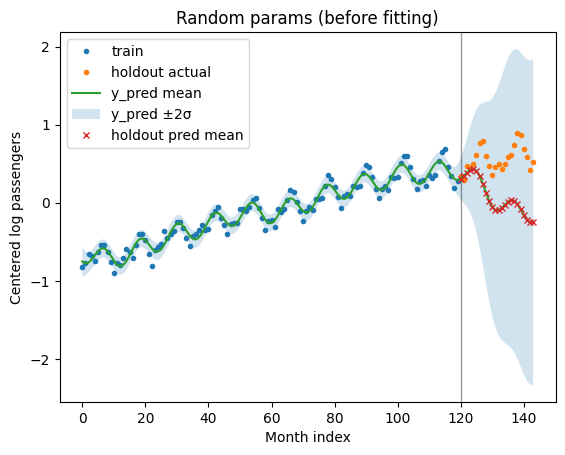

Random init RMSE: 0.56 — this is why we need to optimize!


In [9]:
def gp_posterior_predictive(X_train: Array, y_train: Array, X_test: Array,
                            kernel: Kernel, p: Params, noise_log_sigma: float) -> Tuple[Array, Array]:
    """Return predictive mean and marginal variance for test points."""
    n = X_train.shape[0]
    K = kernel(X_train, None, p)
    sigma_n = _safe_exp(noise_log_sigma)
    K = K + (sigma_n ** 2) * np.eye(n)

    Ks = kernel(X_train, X_test, p)
    Kss = kernel(X_test, None, p)

    L, _ = stable_cholesky(K)
    alpha = solve_cholesky(L, y_train)
    mu = Ks.T @ alpha

    v = np.linalg.solve(L, Ks)
    var = np.diag(Kss) - np.sum(v * v, axis=0)
    var = np.maximum(var, 1e-12)
    return mu, var


def plot_gp_train_holdout_fit(
    kernel: Kernel,
    p: Params,
    noise_log_sigma: float,
    title: str,
    *,
    n_plot: int = 300,
    show: bool = True,
) -> float:
    """Plot train vs holdout, plus predictive mean/±2σ, and return holdout RMSE.

    Uses global: X_train, y_train, X_holdout, y_holdout, X_full, split_idx.
    """
    X_plot = np.linspace(X_full.min(), X_full.max(), n_plot)

    y_pred_mean_plot, y_pred_var_plot = gp_posterior_predictive(
        X_train, y_train, X_plot, kernel, p, noise_log_sigma
    )
    y_pred_mean_holdout, _ = gp_posterior_predictive(
        X_train, y_train, X_holdout, kernel, p, noise_log_sigma
    )

    plt.figure()
    plt.plot(X_train, y_train, "o", markersize=3, label="train")
    plt.plot(X_holdout, y_holdout, "o", markersize=3, label="holdout actual")
    plt.axvline(X_full[split_idx], color="k", lw=1, alpha=0.4)

    plt.plot(X_plot, y_pred_mean_plot, label="y_pred mean")
    plt.fill_between(
        X_plot,
        y_pred_mean_plot - 2 * np.sqrt(y_pred_var_plot),
        y_pred_mean_plot + 2 * np.sqrt(y_pred_var_plot),
        alpha=0.2,
        label="y_pred ±2σ",
    )
    plt.plot(X_holdout, y_pred_mean_holdout, "x", markersize=5, label="holdout pred mean")

    plt.title(title)
    plt.xlabel("Month index")
    plt.ylabel("Centered log passengers")
    plt.legend()
    if show:
        plt.show()

    rmse = float(np.sqrt(np.mean((y_pred_mean_holdout - y_holdout) ** 2)))
    return rmse


# Sanity check: plot with random init to show why we need to fit params
k_demo = Sum(Periodic(name="demo_per"), RBF(name="demo_rbf"))
p_demo = init_params_for_kernel(k_demo)
noise_demo = math.log(0.15)

rmse_random = plot_gp_train_holdout_fit(k_demo, p_demo, noise_demo, "Random params (before fitting)")
print(f"Random init RMSE: {rmse_random:.2f} — this is why we need to optimize!")


### 2. Fixed kernel structure — fit hyperparameters (MAP)

**GP Model:**
- Latent function: $f \sim \mathbf{GP}(0, k_\theta)$
- Observations: $y = f(t) + \epsilon,\; \epsilon \sim \mathbf{N}(0, \sigma_n^2 I)$

**Log marginal likelihood:**
$$
\log p(y\mid\theta) = -\tfrac{1}{2} y^T K^{-1} y - \tfrac{1}{2}\log|K| - \tfrac{n}{2}\log(2\pi)
$$

We hold the kernel structure fixed and fit only its continuous hyperparameters by maximizing the log posterior:
$$
\theta_{\text{MAP}} = \arg\max_\theta\; \log p(y\mid k,\theta) + \log p(\theta)
$$

This is not full Bayesian marginalization over $\theta$, but it's a useful first step to see whether a given structure can fit the data.

In [10]:
# === Fixed-kernel hyperparameter inference ===
#
# Given a fixed kernel structure, find good hyperparameters θ = (params, noise).
#
# AVAILABLE UTILITIES:
#   - log_posterior(X, y, kernel, params, noise) -> log p(θ | data)
#   - init_params_for_kernel(kernel) -> random initial params
#   - plot_gp_train_holdout_fit(kernel, params, noise, title) -> rmse

import scipy.optimize

# Example fixed kernel structure
k_fixed = Sum(Periodic(name="per_fix"), RBF(name="rbf_fix"))


def fit_map_for_fixed_kernel(kernel: Kernel) -> tuple[Params, float, float]:
    """Fit MAP hyperparameters using scipy.optimize (L-BFGS-B).

    Returns: (p_map, noise_map, neg_log_post)
    """
    names = kernel.param_names()

    def pack(p: Params, noise: float) -> np.ndarray:
        return np.array([p[n] for n in names] + [noise])

    def unpack(x: np.ndarray) -> tuple[Params, float]:
        return {names[i]: float(x[i]) for i in range(len(names))}, float(x[-1])

    def objective(x: np.ndarray) -> float:
        try:
            p, noise = unpack(x)
            val = -log_posterior(X_train, y_train, kernel, p, noise)
            return float(val) if np.isfinite(val) else 1e10
        except:
            return 1e10

    # Initialize from prior
    p0 = init_params_for_kernel(kernel, scale=0.3)
    noise0 = np.random.default_rng(0).normal(math.log(0.1), 0.3)
    x0 = pack(p0, noise0)

    # Optimize with bounds to prevent extreme values
    bounds = [(-10, 10)] * len(x0)
    result = scipy.optimize.minimize(objective, x0, method="L-BFGS-B", bounds=bounds)

    p_map, noise_map = unpack(result.x)
    return p_map, noise_map, float(result.fun)


**Plotting Results**:

Fixed kernel: (Periodic(per_fix) + RBF(rbf_fix))
MAP -log posterior: -50.97680845447992


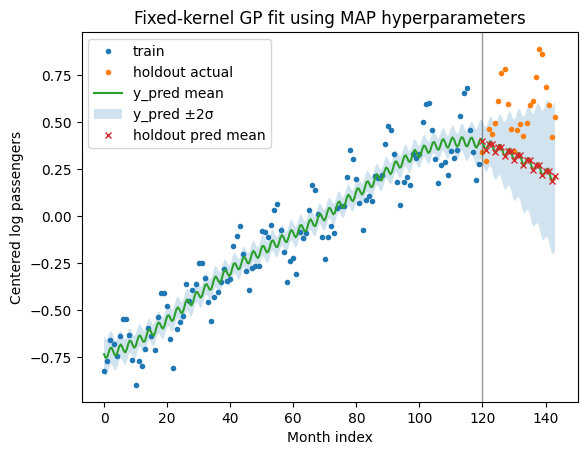

Holdout RMSE (log-space): 0.3147141594353751


In [11]:
p_map, noise_map, neg_lp = fit_map_for_fixed_kernel(k_fixed)
print("Fixed kernel:", k_fixed.pretty())
print("MAP -log posterior:", neg_lp)
rmse_map = plot_gp_train_holdout_fit(
    k_fixed, p_map, noise_map,
    "Fixed-kernel GP fit using MAP hyperparameters",
)
print("Holdout RMSE (log-space):", rmse_map)



## 3. MCMC intuition (Metropolis–Hastings)

The paper samples expressions from the posterior using an MCMC chain. A proposal step:
1. Select a random node in the parse tree
2. Sever the subtree to create a hole
3. Expand a new subtree from the grammar
4. Accept or reject the mutation using a Metropolis–Hastings ratio

This guarantees a valid Markov chain whose stationary distribution matches the posterior (under mild conditions), but it is expensive to implement in full generality.

**In this notebook**, we use a lightweight MCMC-style mutation that *does* implement `Sever`/`Expand`, and then adapt grammar weights from the top candidates. It is still simplified (MAP fits and a basic acceptance ratio), but it exercises the same mutation mechanics as the paper.

## 4. Kernel Structure Search with Grammar Adaptation

### Objective

Given a **kernel grammar** that can generate random kernel expressions, we want to:
1. **Search** for kernel structures that fit the data well
2. **Adapt** the grammar probabilities based on what works

### Approach: MCMC + Grammar Update

We follow the paper’s MCMC mutation (Sever/Expand), but **updating the grammar *probabilities* from the top candidates is a small twist** added for this notebook (the grammar structure itself is fixed).

Since our proposals are independent (sampled fresh from the grammar), we use **random search**:
1. Sample $N$ kernels from the current grammar
2. Fit hyperparameters for each (MAP)
3. Rank by holdout RMSE
4. Update grammar weights based on top-$k$ kernels, using exponential moving average
5. Repeat for multiple rounds

This keeps the flow simple and makes it easy to see how structure search and grammar adaptation interact.

### Available Utilities

- `sample_kernel_grammar(rng, depth, grammar)` — sample kernel from grammar
- `fit_map_for_fixed_kernel(kernel)` — MAP fit for hyperparameters  
- `plot_gp_train_holdout_fit(kernel, params, noise, title)` — plot and return RMSE
- `GrammarParams` — grammar configuration with `.default()` and `.normalized()`


In [12]:
# === Adaptive random search implementation ===
# Random kernel search with grammar adaptation

from dataclasses import dataclass
import os

from kernel_viz import render_kernel_graph


@dataclass
class StructState:
    kernel: Kernel
    log_score: float
    p_map: Params
    noise_map: float


def _is_degenerate(k: Kernel) -> bool:
    match k:
        case White() | Product(left=White()) | Product(right=White()): return True
        case _: return False


def _kernel_counts(k: Kernel) -> tuple[int, int, dict[str, int]]:
    """Return (n_sum, n_prod, base_counts)."""
    base = {"rbf": 0, "per": 0, "lin": 0, "wn": 0}
    match k:
        case Sum(left=l, right=r):
            s1, p1, b1 = _kernel_counts(l)
            s2, p2, b2 = _kernel_counts(r)
            return 1 + s1 + s2, p1 + p2, {k: b1[k] + b2[k] for k in base}
        case Product(left=l, right=r):
            s1, p1, b1 = _kernel_counts(l)
            s2, p2, b2 = _kernel_counts(r)
            return s1 + s2, 1 + p1 + p2, {k: b1[k] + b2[k] for k in base}
        case RBF(): base["rbf"] = 1
        case Periodic(): base["per"] = 1
        case Linear(): base["lin"] = 1
        case White(): base["wn"] = 1
    return 0, 0, base


def _holdout_rmse(k: Kernel, p: Params, noise: float) -> float:
    y_pred, _ = gp_posterior_predictive(X_train, y_train, X_holdout, k, p, noise)
    return float(np.sqrt(np.mean((y_pred - y_holdout) ** 2)))


def _kernel_nodes_with_paths(k: Kernel, path: tuple[str, ...] = ()) -> list[tuple[tuple[str, ...], Kernel]]:
    nodes = [(path, k)]
    match k:
        case Sum(left=l, right=r) | Product(left=l, right=r):
            nodes += _kernel_nodes_with_paths(l, path + ("L",))
            nodes += _kernel_nodes_with_paths(r, path + ("R",))
    return nodes


def _replace_subtree(k: Kernel, path: tuple[str, ...], new_subtree: Kernel) -> Kernel:
    if len(path) == 0:
        return new_subtree
    head, *rest = path
    match k:
        case Sum(left=l, right=r):
            if head == "L":
                return Sum(_replace_subtree(l, tuple(rest), new_subtree), r)
            return Sum(l, _replace_subtree(r, tuple(rest), new_subtree))
        case Product(left=l, right=r):
            if head == "L":
                return Product(_replace_subtree(l, tuple(rest), new_subtree), r)
            return Product(l, _replace_subtree(r, tuple(rest), new_subtree))
        case _:
            return new_subtree


def _kernel_to_str_with_highlight(k: Kernel, highlight_path: tuple[str, ...] | None) -> str:
    def rec(node: Kernel, path: tuple[str, ...]) -> str:
        match node:
            case Sum(left=l, right=r):
                s = f"({rec(l, path + ('L',))} + {rec(r, path + ('R',))})"
            case Product(left=l, right=r):
                s = f"({rec(l, path + ('L',))} * {rec(r, path + ('R',))})"
            case _:
                s = node.pretty()
        if highlight_path is not None and path == highlight_path:
            return f"[[{s}]]"
        return s

    return rec(k, ())


def visualize_kernel_mutation(k_before: Kernel, k_after: Kernel, sever_path: tuple[str, ...]) -> None:
    print("Sever path:", "root" if len(sever_path) == 0 else "".join(sever_path))
    print("Before:", _kernel_to_str_with_highlight(k_before, sever_path))
    print("After :", _kernel_to_str_with_highlight(k_after, sever_path))


def sever_kernel(rng: np.random.Generator, k: Kernel) -> tuple[str, tuple[str, ...]]:
    """Pick a random node and return (nonterminal, hole-path)."""
    nodes = _kernel_nodes_with_paths(k)
    path, _ = nodes[int(rng.integers(len(nodes)))]
    return "K", path


def expand_from_grammar(
    rng: np.random.Generator,
    depth: int,
    grammar: GrammarParams,
) -> Kernel:
    return sample_kernel_grammar(rng, depth, grammar)


def mutate_kernel(
    rng: np.random.Generator,
    k: Kernel,
    depth: int,
    grammar: GrammarParams,
) -> tuple[Kernel, int, int, tuple[str, ...]]:
    """Sever a subtree and expand a replacement from the grammar."""
    nodes_before = _kernel_nodes_with_paths(k)
    _, hole_path = sever_kernel(rng, k)
    new_subtree = expand_from_grammar(rng, depth, grammar)
    k_new = _replace_subtree(k, hole_path, new_subtree)
    nodes_after = _kernel_nodes_with_paths(k_new)
    return k_new, max(1, len(nodes_before)), max(1, len(nodes_after)), hole_path


def _log_prior_structure(k: Kernel, grammar: GrammarParams) -> float:
    g = grammar.normalized()
    n_sum, n_prod, base = _kernel_counts(k)
    p_base = max(1e-6, 1.0 - g.p_sum - g.p_prod)
    logp = 0.0
    for key, count in base.items():
        if count > 0:
            logp += count * (math.log(p_base) + math.log(g.base_weights.get(key, 1e-6)))
    if n_sum > 0:
        logp += n_sum * math.log(max(1e-6, g.p_sum))
    if n_prod > 0:
        logp += n_prod * math.log(max(1e-6, g.p_prod))
    return float(logp)


def _score_kernel(
    k: Kernel,
    grammar: GrammarParams,
) -> tuple[Params, float, float]:
    p, noise, neg_lp = fit_map_for_fixed_kernel(k)
    log_post = -neg_lp + _log_prior_structure(k, grammar)
    return p, noise, float(log_post)


def mcmc_kernel_chain(
    num_steps: int,
    depth: int,
    grammar: GrammarParams,
    rng: np.random.Generator,
    burn_in: int = 0,
    thin: int = 1,
    verbose: bool = True,
    viz_dir: str | None = None,
    viz_every: int = 1,
) -> tuple[list[StructState], float]:
    """MCMC chain using Sever/Expand mutations and MH acceptance."""
    g = grammar.normalized()

    # Initialize from the grammar prior
    for _ in range(100):
        k0 = sample_kernel_grammar(rng, depth, g)
        if not _is_degenerate(k0):
            p0, n0, s0 = _score_kernel(k0, g)
            if np.isfinite(s0):
                break
    current = StructState(k0, s0, p0, n0)

    samples: list[StructState] = []
    accepted = 0

    if viz_dir:
        os.makedirs(viz_dir, exist_ok=True)

    if verbose:
        print("Init:", current.kernel.pretty())

    for step in range(num_steps):
        k_before = current.kernel
        s_before = current.log_score

        # Propose via Sever/Expand
        for _ in range(20):
            k_prop, n_a, n_b, hole_path = mutate_kernel(rng, k_before, depth, g)
            if not _is_degenerate(k_prop):
                break

        p_prop, n_prop, s_prop = _score_kernel(k_prop, g)
        log_alpha = (s_prop - current.log_score) + (math.log(n_a) - math.log(n_b))
        accepted_step = math.log(rng.random()) < log_alpha
        if accepted_step:
            current = StructState(k_prop, s_prop, p_prop, n_prop)
            accepted += 1

        if verbose:
            status = "accept" if accepted_step else "reject"
            print(f"Step {step:03d} | {status} | log_alpha={log_alpha:.3f}")
            visualize_kernel_mutation(k_before, k_prop, hole_path)

        if viz_dir and (step % max(1, viz_every) == 0):
            prefix = f"step_{step:03d}_{'accept' if accepted_step else 'reject'}"
            before_path = os.path.join(viz_dir, f"{prefix}_before.png")
            after_path = os.path.join(viz_dir, f"{prefix}_after.png")
            render_kernel_graph(
                k_before,
                highlight_path=hole_path,
                score=s_before,
                title=f"Step {step:03d} before",
                save_path=before_path,
            )
            render_kernel_graph(
                k_prop,
                highlight_path=hole_path,
                score=s_prop,
                title=f"Step {step:03d} after",
                save_path=after_path,
            )

        if step >= burn_in and ((step - burn_in) % thin == 0):
            samples.append(current)

    acc_rate = accepted / max(1, num_steps)
    return samples, acc_rate


def top_k_from_samples(samples: list[StructState], top_k: int) -> list[StructState]:
    import heapq
    top: list[tuple[float, StructState]] = []
    for st in samples:
        if len(top) < top_k:
            heapq.heappush(top, (st.log_score, st))
        elif st.log_score > top[0][0]:
            heapq.heapreplace(top, (st.log_score, st))
    return [s for _, s in sorted(top, key=lambda x: -x[0])]


def random_kernel_search(
    num_samples: int, depth: int, grammar: GrammarParams, rng: np.random.Generator,
    top_k: int = 5,
) -> list[StructState]:
    """Sample N kernels from grammar, fit each, return top-k by score."""
    import heapq
    g = grammar.normalized()
    top_results: list[StructState] = []

    for _ in range(num_samples):
        # Sample non-degenerate kernel
        for _ in range(20):
            k = sample_kernel_grammar(rng, depth, g)
            if not _is_degenerate(k):
                break

        # Fit hyperparameters
        p, noise, neg_lp = fit_map_for_fixed_kernel(k)
        score = -neg_lp  # log posterior
        state = StructState(k, score, p, noise)

        # Keep only top-k (using min-heap by score)
        if len(top_results) < top_k:
            heapq.heappush(top_results, (score, state))
        elif score > top_results[0][0]:
            heapq.heapreplace(top_results, (score, state))

    # Return sorted by score (best first)
    return [state for _, state in sorted(top_results, key=lambda x: -x[0])]


def update_grammar_from_top_kernels(
    kernels: list[Kernel], prev: GrammarParams, smoothing: float,
) -> GrammarParams:
    """Update grammar weights based on good kernels found."""
    base = {"rbf": 0, "per": 0, "lin": 0, "wn": 0}
    s_ct, p_ct = 0, 0
    for k in kernels:
        s, p, b = _kernel_counts(k)
        s_ct += s
        p_ct += p
        for kk in base:
            base[kk] += b[kk]

    tot_base = sum(base.values()) or 1
    new_base = {k: base[k] / tot_base for k in base}
    tot_ops = s_ct + p_ct or 1
    new_ps, new_pp = s_ct / tot_ops * 0.7, p_ct / tot_ops * 0.7

    blended = {k: (1 - smoothing) * prev.base_weights.get(k, 0.25) + smoothing * new_base[k] for k in base}
    ps = (1 - smoothing) * prev.p_sum + smoothing * new_ps
    pp = (1 - smoothing) * prev.p_prod + smoothing * new_pp
    return GrammarParams(blended, max(0.05, min(0.45, ps)), max(0.05, min(0.45, pp)))


def adaptive_kernel_search(
    *, rounds: int, samples_per_round: int, depth: int, top_k: int,
    smoothing: float, rng: np.random.Generator,
) -> tuple[Kernel, Params, float, GrammarParams]:
    """Multi-round random search with grammar adaptation."""
    g = GrammarParams.default()
    best_overall: StructState | None = None
    best_rmse = float("inf")

    for r in range(1, rounds + 1):
        samples, acc_rate = mcmc_kernel_chain(
            samples_per_round,
            depth,
            g,
            rng,
            burn_in=max(0, samples_per_round // 10),
            thin=1,
        )
        top_k_states = top_k_from_samples(samples, top_k=top_k)

        # Score by holdout RMSE and find best
        for st in top_k_states:
            rmse = _holdout_rmse(st.kernel, st.p_map, st.noise_map)
            if rmse < best_rmse:
                best_rmse = rmse
                best_overall = st

        # Update grammar from top kernels
        g = update_grammar_from_top_kernels([st.kernel for st in top_k_states], g, smoothing)
        print(f"Round {r}/{rounds} | accept_rate={acc_rate:.3f} | best_rmse={best_rmse:.4f} | grammar={g}")

    assert best_overall is not None
    return best_overall.kernel, best_overall.p_map, best_overall.noise_map, g


In [13]:
# Run adaptive random kernel search
rng = np.random.default_rng(2025)
best_k, best_p, best_noise, learned_gp = adaptive_kernel_search(
    rounds=5,
    samples_per_round=15,
    depth=3,
    top_k=5,
    smoothing=0.3,
    rng=rng,
)

Init: Periodic(per953587)
Step 000 | reject | log_alpha=-15.961
Sever path: root
Before: [[Periodic(per953587)]]
After : [[((Periodic(per635632) + (RBF(rbf285824) * RBF(rbf479755))) + Periodic(per153436))]]
Step 001 | accept | log_alpha=109.253
Sever path: root
Before: [[Periodic(per953587)]]
After : [[(((RBF(rbf143247) + Periodic(per579020)) + RBF(rbf321948)) * ((White(wn496302) * White(wn996288)) + RBF(rbf760100)))]]
Step 002 | reject | log_alpha=-91.246
Sever path: L
Before: ([[((RBF(rbf143247) + Periodic(per579020)) + RBF(rbf321948))]] * ((White(wn496302) * White(wn996288)) + RBF(rbf760100)))
After : ([[Periodic(per804581)]] * ((White(wn496302) * White(wn996288)) + RBF(rbf760100)))
Step 003 | reject | log_alpha=-294.384
Sever path: RR
Before: (((RBF(rbf143247) + Periodic(per579020)) + RBF(rbf321948)) * ((White(wn496302) * White(wn996288)) + [[RBF(rbf760100)]]))
After : (((RBF(rbf143247) + Periodic(per579020)) + RBF(rbf321948)) * ((White(wn496302) * White(wn996288)) + [[(((Linear(li

Best kernel: (((RBF(rbf82798) + Periodic(per749869)) * (RBF(rbf717284) + RBF(rbf451214))) * RBF(rbf304234))
Learned grammar: GrammarParams(base_weights={'rbf': 0.5837314999999998, 'per': 0.3058375, 'lin': 0.03361399999999999, 'wn': 0.07681699999999998}, p_sum=0.4300995999999999, p_prod=0.26990039999999993)


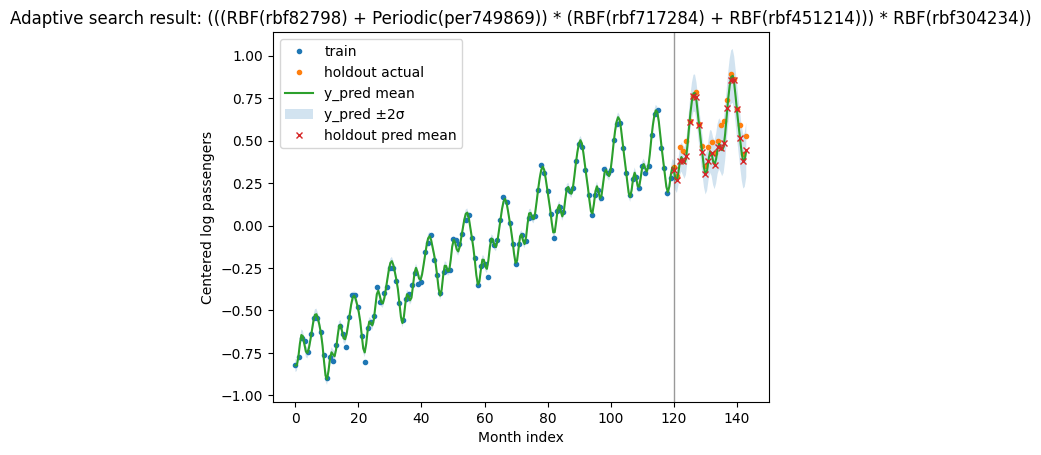

Holdout RMSE: 0.0619


In [14]:
# Plot the best kernel found
print("Best kernel:", best_k.pretty())
print("Learned grammar:", learned_gp)

rmse = plot_gp_train_holdout_fit(
    best_k, best_p, best_noise,
    f"Adaptive search result: {best_k.pretty()}",
)
print(f"Holdout RMSE: {rmse:.4f}")
